First of all, let's import necessary libraries/packages we are going to work with.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

 Now, let's load the data.

In [80]:
df_complete = pd.read_csv('df_complete.csv')
df =  pd.read_csv('df_train.csv', index_col=0)
df = df.asfreq('b')
df_test = pd.read_csv('df_test.csv')

Before we go back to code, it's important to know an important concept regarding time series and picking the correct model to work with. 
White Noise is a special type of time series where data doesn't follow a pattern. In time series, patterns found in the past, also persist in the future. Thus, we can't predict White Noise, because it doesn't follow a pattern.

In order to consider a time series as a white noise, it needs to satisfy the following three conditions: 1) A constant mean; 2) A constant variance and; 3) No autocorrelation in any period (i.e. there is no clear relationship between past and present values of time series).

To make it clear, let's create a white noise and compare with S&P.

In [81]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size=len(df))

In [82]:
df['wn'] = wn

In [83]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1096.095122
std,292.559287,292.204061
min,438.920000,5.894715
25%,914.620000,898.712535
50%,1144.650000,1095.239893
75%,1316.280729,1292.965130
max,1570.252238,2113.025346


Let's plot white noise and market_value

Text(0.5,1,'White Noise time-series')

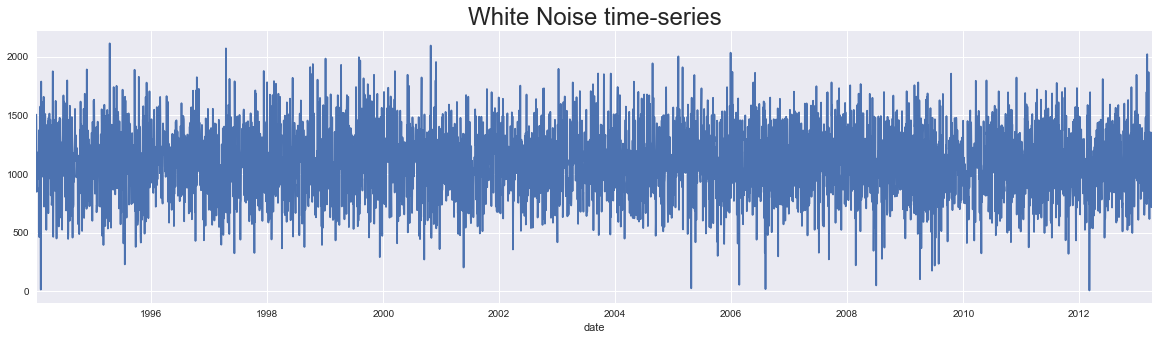

In [84]:
plt.figure(figsize=(20,5))
df.wn.plot()
plt.title("White Noise time-series", size=24)

Text(0.5,1,'S&P Prices')

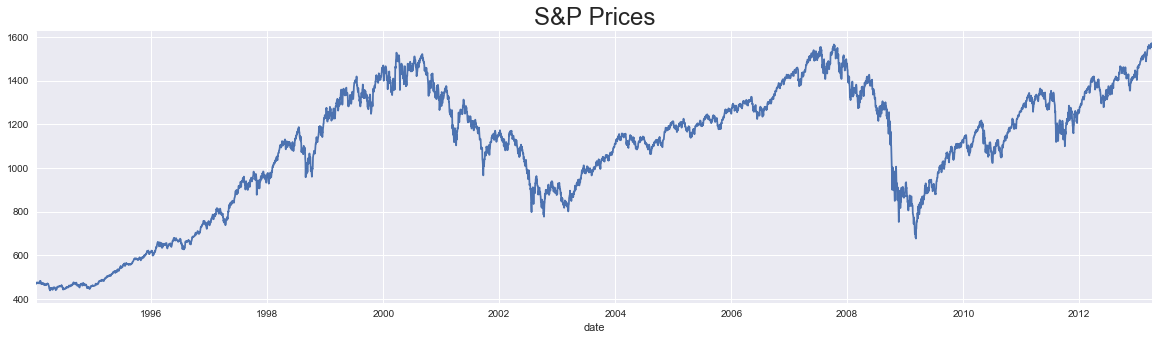

In [85]:
plt.figure(figsize=(20,5))
df.market_value.plot()
plt.title("S&P Prices", size=24)

Notice that plots don't have the same magnitude. Let's fix this.

Text(0.5,1,'S&P Prices')

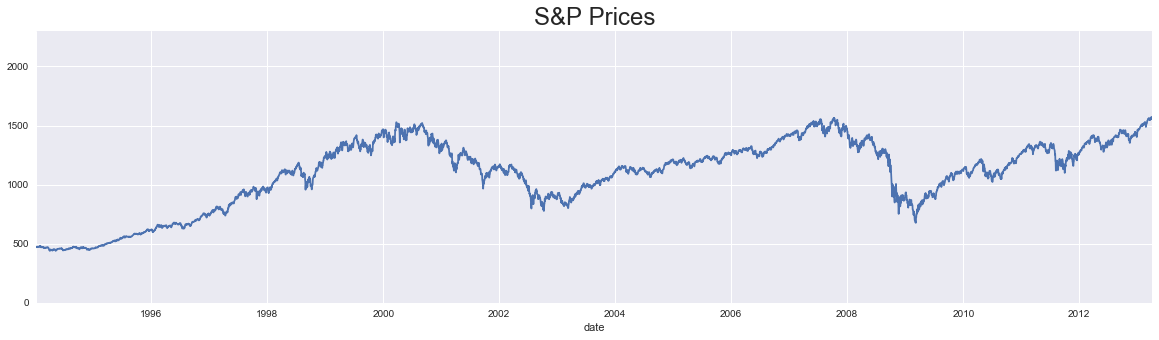

In [86]:
plt.figure(figsize=(20,5))
df.market_value.plot()
plt.ylim(0,2300)
plt.title("S&P Prices", size=24)

There are far smaller jumps between periods for S&P values. Since the prices are not random, we need to recognize the pattern to make accurate forecasts.

Another time-series type is Random Walk (RW). RW is a special type of time-series, where values tend to persist over time and the differences between periods are simply white noise. 

So, Price in time t is equal to Price in time t-1 and a residual (i.e. the white noise in this case). Pt = P(t-1)+e.

Let's take a look at Random Walk time-series.

In [87]:
rw = pd.read_csv('RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst=True)
rw.set_index("date", inplace=True)
rw = rw.asfreq('b')

In [88]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [89]:
df['rw']=rw['price']

In [90]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1505.114444,1122.139662
1994-01-10,475.27,1139.103015,1080.347860
1994-01-11,474.13,847.234674,1082.095245
1994-01-12,474.17,1127.229036,1083.639265
1994-01-13,472.47,952.361346,1067.146255


Now, let's plot the RW time-series.

Text(0.5,1,'Random Walk')

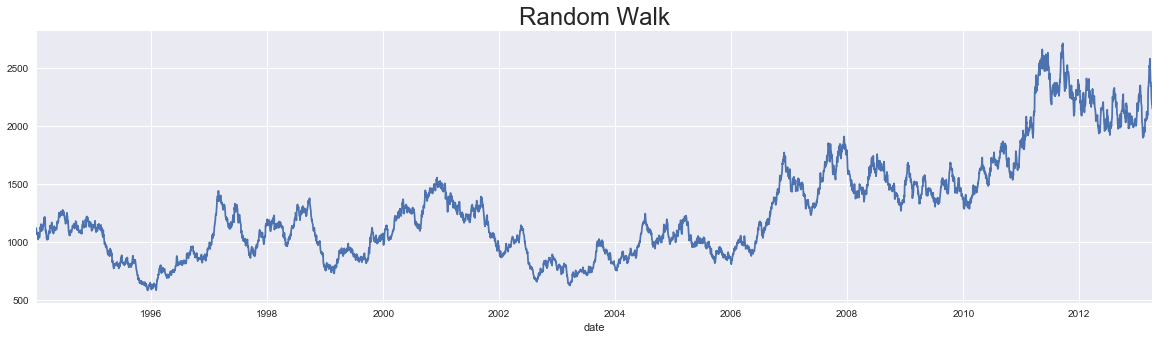

In [91]:
plt.figure(figsize=(20,5))
df.rw.plot()
#plt.ylim(0,2300)
plt.title("Random Walk", size=24)

In order to better compare the graphs, let's plot them together.

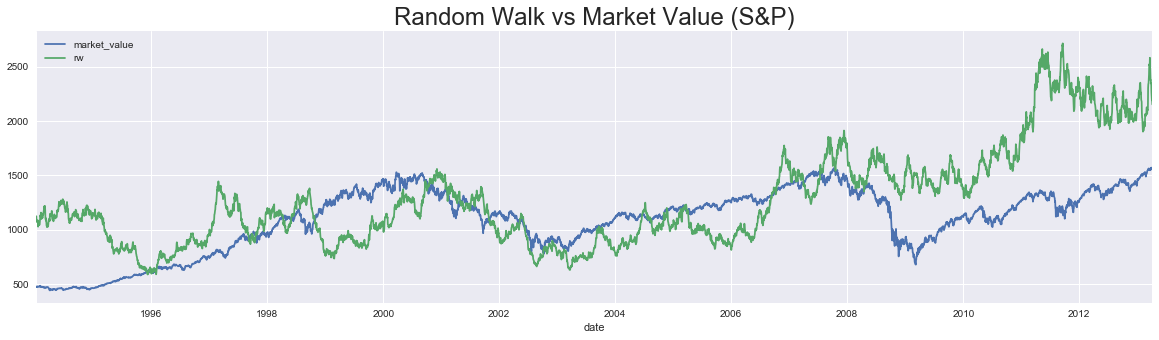

In [92]:
plt.figure(figsize=(20,5))
df.market_value.plot()
df.rw.plot()
plt.title("Random Walk vs Market Value (S&P)", size=24)
plt.legend()

Analysing the graph, we can see both time-series have small variations between consecutive time periods. Moreover, both have cyclical increases and decreases in short periods of time.

Another important term related to time-series is Stationarity. For the sake of simplicity, stationarity has three assumptions: 
    1) Constant mean; 2) Constant variance; 3) Covariances between two intervals with the same lenght are equal.

In order to check the stationarity, we need to check the hypothesis test where: Null Hypothesis (Ho) states there is the presence of a unit root, and Alternate Hypothesis (Ha) states there is no unit root. In other words, Stationarity exists. Using a level of significance of 5%, if the p-value is greater than 5%, we accept the Ho. Otherwise, we reject Ho and accept Ha, considering the time-serie stationary.

To test the hypothesis, we use Dickey-Fuller test.

In [93]:
import statsmodels.tsa.stattools as sts
sts.adfuller(df.market_value)

(-1.7369847452352385,
 0.4121645696770649,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

The second element of the tupple is the p-value. As it is 41.21%, meaning this is greater than 5%, we accept the Ho and reject Ha. Thus, we can't confirm the time-serie is stationary.

The third element represents the number of lags used in the regression. In this case, there are some autocorrelation going back 18 periods.

Let's analyze white noise time-serie. 

In [94]:
sts.adfuller(df.wn)

(-41.547888989136155,
 0.0,
 2,
 5018,
 {'1%': -3.4316538358533277,
  '5%': -2.8621161549128313,
  '10%': -2.567076687880585},
 70787.80484094015)

Notice p-value is less than 5%. Thus, we reject Ho and accept Ha, meaning this time-serie is stationary. 

Now let's check if random walk is stationary.

In [95]:
sts.adfuller(df.rw)

(-1.3286073927689706,
 0.615984918161739,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

The p-value is 61.59%, meaning this is greater than 5%. We accept the Ho and reject Ha. Thus, we can't confirm the time-serie is stationary.

Let's check now the seasonality, which suggests that certain trends will appear on a cyclical basis.

There are several ways of testing for seasonality. Let's use decomposition approach, that slipts up the time series into three effects: Trend, Seasonal and Residual.

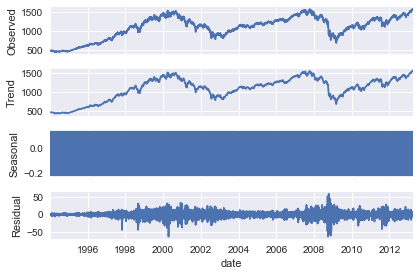

In [100]:
from statsmodels.tsa.seasonal import seasonal_decompose
s_dec_additive = seasonal_decompose(df.market_value, model='additive')
s_dec_additive.plot();

The results suggest no seasonality in the data.

Now, let's calculate the Autocorrelation. Correlation measures the similarity in the change of values of two series. As we only have one serie, we are going to work with autocorrelation. 
Thus, autocorrelation is a correlation between a sequence and itself.

In [101]:
import statsmodels.graphics.tsaplots as sgt

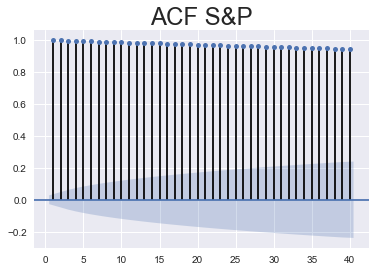

In [102]:
sgt.plot_acf(df.market_value, lags=40, zero = False)
plt.title("ACF S&P", size=24);

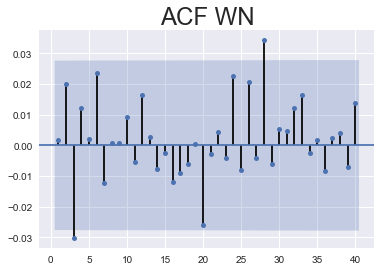

In [104]:
sgt.plot_acf(df.wn, lags=40, zero = False)
plt.title("ACF WN", size=24);

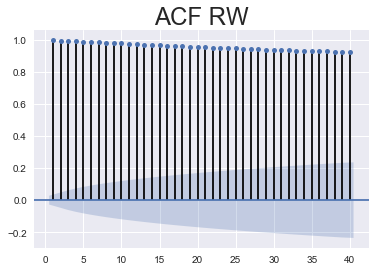

In [105]:
sgt.plot_acf(df.rw, lags=40, zero = False)
plt.title("ACF RW", size=24);

Now, if we wish to determine only the direct relationship between  the time series and its lagged version, we need to compute the partial auto correlation.

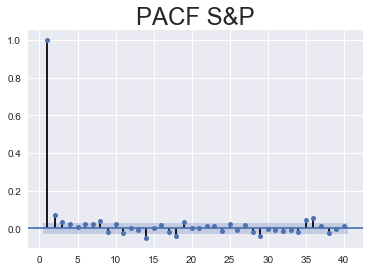

In [110]:
sgt.plot_pacf(df.market_value, lags=40, zero = False, method=('ols'))
plt.title("PACF S&P", size=24);

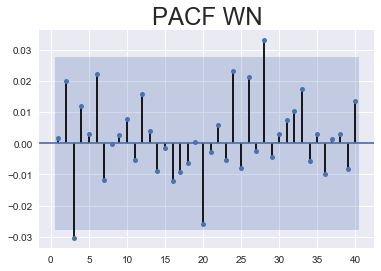

In [111]:
sgt.plot_pacf(df.wn, lags=40, zero = False, method=('ols'))
plt.title("PACF WN", size=24);

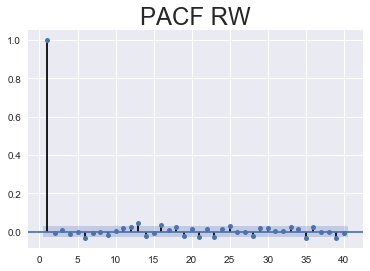

In [112]:
sgt.plot_pacf(df.rw, lags=40, zero = False, method=('ols'))
plt.title("PACF RW", size=24);